# Linear Discriminant Analysis (LDA) [50 pts]
In this part of the exercise, you will re-visit the problem of predicting whether a student gets admitted into a university. However, in this part, you will build a linear discriminant analysis (LDA) classifier for this problem.

LDA is a generative model for classification that assumes the class covariances are equal. Given a training dataset of positive and negative features (x, y) with y $\in$ {0, 1} , LDA models the data x as generated from class-conditional Gaussians:

$P(x, y) = P(x|y)P(y)$ where $P(y = 1) = \pi$ and $P(x|y) = N(x;\mu^y,\Sigma)$

where means $\mu^y$ are class-dependent but the covariance matrix $\Sigma$ is class-independent (the same for all classes).

A novel feature $x$ is classified as a positive if $P(y = 1|x) > P(y = 0|x)$, whichis equivalent to $a(x)\gt0$, where the linear classifier $a(x) = w^Tx+w_0$ has weights given by $w = \Sigma^{-1}(\mu^1-\mu^0)$.

In practice, and in this assignment, we use $a(x)\gt$ some threshold, or equivalently, $w^Tx>T$ for some constant $T$.

As we saw in lecture, LDA and logistic regression can be expressed in the same form

$P(y=1|x) = \frac{1}{1+e^{-\theta^Tx}}.$

However, they generally produce different solutions for the parameter theta.

## Implementation

In this assignment, you can assume the prior probabilities for the two classes are the same (although the number of the positive and negative samples in the training data is not the same), and that the threshold $T$ is zero. As a bonus, you are encouraged to explore how the different prior probabilities shift the decision boundary.

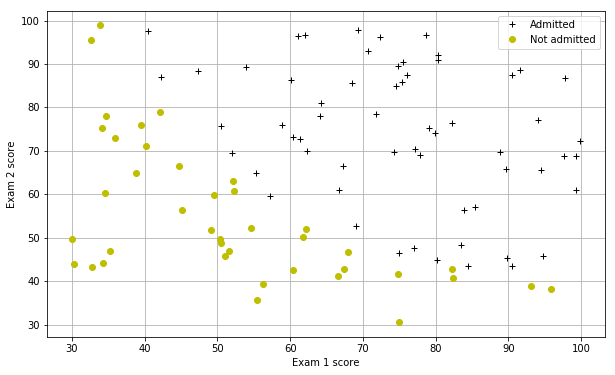

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

datafile = 'data/ex2data1.txt'
#!head $datafile
cols = np.loadtxt(datafile, delimiter=',', usecols=(0, 1, 2), unpack=True)  #Read in comma separated data
##Form the usual "X" matrix and "y" vector
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size  # number of training examples
##Insert the usual column of 1's into the "X" matrix
X = np.insert(X, 0, 1, axis=1)

#Divide the sample into two: ones with positive classification, one with null classification
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

def plotData():
    plt.figure(figsize=(10, 6))
    plt.plot(pos[:, 1], pos[:, 2], 'k+', label='Admitted')
    plt.plot(neg[:, 1], neg[:, 2], 'yo', label='Not admitted')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend()
    plt.grid(True)

plotData()


Implement the LDA classifier by completing the code here. As an implementation detail, you should first center the positive and negative data separately, so that each has a mean equal to 0, before computing the covariance, as this tends to give a more accurate estimate. 

You should center the whole training data set before applying the classifier. Namely, subtract the middle value of the two classes’ means (12(pos mean+neg mean)), which is on the separating plane when their prior probabilities are the same and becomes the ‘center’ of the data. [10pts]

In [2]:
pos_mean = np.mean(pos[:,1:], axis=0)
neg_mean = np.mean(neg[:,1:], axis=0)

pos_data = pos[:,1:] - pos_mean
neg_data = neg[:,1:] - neg_mean

Implement the LDA algorithm here: [10 pts each for getting cov_all, w and y_lda]

In [3]:
cov_all = np.cov(np.concatenate((pos_data, neg_data), axis=0).T)
w = np.linalg.solve(cov_all,(pos_mean - neg_mean))
y_lda = np.transpose(w).dot(np.transpose(X[:,1:]- np.kron(np.ones((len(X), 1)),(1/2*(pos_mean + neg_mean)))))
y_lda = y_lda > 0;

Completing the code to compute the training set accuracy. You should get a training accuracy around 89%. [10 pts]

In [4]:
accuracy = 1 - np.sum(np.abs(y_lda.reshape((100,1)) - y))/ len(y);
accuracy = accuracy * 100;
print(accuracy)

89.0


## Written Problem

Show that the log-odds decision function a(x) for LDA

$a = \ln \frac{p(x|C_1)p(C_1)}{p(x|C_2)p(C_2)}$

is linear in x, that is, we can express $a(x)=\theta^Tx$ for some $\theta$. Show all your steps. 


#### ANSWER:

[comment]: <> (your answer below here.)

![solution](data/solution.png)

# CNN on MNIST using TensorFlow&trade; [50 pts]

\* Adapted from official TensorFlow&trade; tour guide.

TensorFlow is a powerful library for doing large-scale numerical computation. One of the tasks at which it excels is implementing and training deep neural networks. In this assignment you will learn the basic building blocks of a TensorFlow model while constructing a deep convolutional MNIST classifier.

What you are expected to implement in this tutorial:

* Create a softmax regression function that is a model for recognizing MNIST digits, based on looking at every pixel in the image

* Use Tensorflow to train the model to recognize digits by having it "look" at thousands of examples

* Check the model's accuracy with MNIST test data

* Build, train, and test a multilayer convolutional neural network to improve the results

Here is a diagram, created with TensorBoard, of the model we will build:

![tensorflow graph](data/graph.png)

## Implement Utilities

### Weight Initialization

To create this model, we're going to need to create a lot of weights and biases. One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons". Instead of doing this repeatedly while we build the model, let's create two handy functions to do it for us.


In [5]:
import tempfile

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


### Convolution and Pooling [5 pts]

Our convolutions uses a stride of one and are zero padded so that the output is the same size as the input. Our pooling is plain old max pooling over 2x2 blocks.


NOTE: FOR ALL THE FOLLOWING CODES, DO NOT IMPLEMENT YOUR OWN VERSION. USE THE BUILT-IN METHODS FROM TENSORFLOW.

Take a look at [TensorFlow API Docs](https://www.tensorflow.org/api_docs/python/).

In [6]:
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


## Build the CNN

### First Convolutional Layer[10 pts]

We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool. The max_pool_2x2 method will reduce the image size to 14x14.

### Second Convolutional Layer[5 pts]

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

### Fully Connected Layer[10 pts]

Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

### SoftmaxLayer[5 pts]

Finally, we add a layer of softmax regression.

In [7]:
def deepnn(x):
    """
    deepnn builds the graph for a deep net for classifying digits.
    Args:
      x: an input tensor with the dimensions (N_examples, 784), where 784 is the
      number of pixels in a standard MNIST image.
    Returns:
      A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
      equal to the logits of classifying the digit into one of 10 classes (the
      digits 0-9). keep_prob is a scalar placeholder for the probability of
      dropout.
    """
    # Reshape to use within a convolutional neural net.
    # Last dimension is for "features" - there is only one here, since images are
    # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 28, 28, 1])

    # First convolutional layer - maps one grayscale image to 32 feature maps.
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # Pooling layer - downsamples by 2X.
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)

    # Second convolutional layer -- maps 32 feature maps to 64.
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # Second pooling layer.
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)

    # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
    # is down to 7x7x64 feature maps -- maps this to 1024 features.
    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])

        h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Map the 1024 features to 10 classes, one for each digit
    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])

        y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2
    return y_conv


## Complete the Graph[10 pts]
We start building the computation graph by creating nodes for the input images and target output classes.

In [8]:
# Import data
mnist = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data', one_hot=True)

# Create the model
x = tf.placeholder(tf.float32, [None, 784])

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

# Build the graph for the deep net
y_conv = deepnn(x)


Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


We can specify a loss function just as easily. Loss indicates how bad the model's prediction was on a single example; we try to minimize that while training across all the examples. Here, our loss function is the cross-entropy between the target and the softmax activation function applied to the model's prediction. As in the beginners tutorial, we use the stable formulation:

In [9]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


First we'll figure out where we predicted the correct label. tf.argmax is an extremely useful function which gives you the index of the highest entry in a tensor along some axis. For example, tf.argmax(y,1) is the label our model thinks is most likely for each input, while tf.argmax(y\_,1) is the true label. We can use tf.equal to check if our prediction matches the truth.

That gives us a list of booleans. To determine what fraction are correct, we cast to floating point numbers and then take the mean. For example, [True, False, True, True] would become [1,0,1,1] which would become 0.75.

In [10]:
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)    
    accuracy = tf.reduce_mean(correct_prediction)

In [11]:
# For saving the graph, DO NOT CHANGE.
graph_location = tempfile.mkdtemp()
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

Saving graph to: /tmp/tmptetx2a70


## Train and Evaluate the Model[5 pts]

We will a more sophisticated ADAM optimizer instead of a Gradient Descent Optimizer.

We will add logging to every 100th iteration in the training process.

Feel free to run this code. Be aware that it does 20,000 training iterations and may take a while (possibly up to half an hour), depending on your processor.

The final test set accuracy after running this code should be approximately 99.2%  -- not state of the art, but respectable.

We have learned how to quickly and easily build, train, and evaluate a fairly sophisticated deep learning model using TensorFlow.

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
        batch = mnist.train.next_batch(50)
        if i % 500 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})

    print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

step 0, training accuracy 0.1
step 500, training accuracy 0.94
step 1000, training accuracy 0.96
step 1500, training accuracy 0.98
step 2000, training accuracy 0.96
step 2500, training accuracy 1
step 3000, training accuracy 1
step 3500, training accuracy 1
step 4000, training accuracy 0.98
step 4500, training accuracy 1
step 5000, training accuracy 1
step 5500, training accuracy 0.98
step 6000, training accuracy 0.98
step 6500, training accuracy 0.98
step 7000, training accuracy 1
step 7500, training accuracy 1
step 8000, training accuracy 1
step 8500, training accuracy 1
step 9000, training accuracy 1
step 9500, training accuracy 1
step 10000, training accuracy 1
step 10500, training accuracy 1
step 11000, training accuracy 1
step 11500, training accuracy 1
step 12000, training accuracy 1
step 12500, training accuracy 1
step 13000, training accuracy 1
step 13500, training accuracy 0.98
step 14000, training accuracy 1
step 14500, training accuracy 1
step 15000, training accuracy 1
ste